# Question 1 Part (c)

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split


# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [10]:
# Import data into a pandas data frame
taxi_trips_df = pd.read_parquet('taxi_trips.parquet')
taxi_trips_df.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,min_of_day,day_of_week,day_of_year
187173,0.270744,1.425051,0.466831,0.776192,-0.007192,-0.942057,-1.047619,1.180855
179655,0.085681,0.306079,-0.226274,0.124111,0.370803,0.778703,-1.047619,-0.311290
120048,-0.555533,-0.934806,-0.022489,-0.548561,-0.434735,-1.183016,-1.047619,1.316504
62587,0.069718,0.035804,0.258900,0.317284,-0.811614,-0.908008,0.481657,0.018144
212063,-0.234482,0.074616,0.115836,0.258310,0.480548,1.066806,-0.537860,0.521985


In [23]:
# Split into features and target
# Assuming the 'trip_duration' is the target column and the other columns are features
X = taxi_trips_df.drop('trip_duration', axis=1).values
y = taxi_trips_df['trip_duration'].values.reshape(-1, 1)

# Split into training, validation, and test sets (80:10:10 split to train:test:val)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val  = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

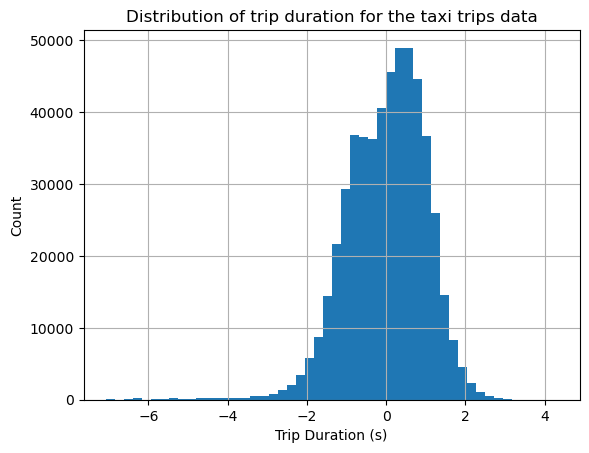

In [132]:
# Plot a distribution of the trip durations
taxi_trips_df['trip_duration'].hist(bins=50)
plt.title('Distribution of trip duration for the taxi trips data')
plt.xlabel('Trip Duration (s)')
plt.ylabel('Count')
plt.show()

In [133]:
# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)

In [115]:
# Construct a MLP model class with 2 hidden layers
class TaxiDurationPredictor(nn.Module):
    def __init__(self, n_features, hidden_1_size, hidden_2_size, n_targets):
        """
        arguments:
        n_features: size of input
        hidden_1_size: size of hidden layer 1
        hidden_2_size: size of hidden layer 2
        n_targets: size of output
        """
        super(TaxiDurationPredictor, self).__init__()
        self.layer1 = nn.Linear(n_features, hidden_1_size)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_1_size, hidden_2_size)
        self.relu2 = nn.ReLU()

        # Mean Parameters
        self.mean_layer = nn.linear

        # Variance Parameters
        self.final_layer = nn.Linear(hidden_2_size, n_targets)
        self.softplus = nn.Softplus()  # Link function for variance

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.layer2(x)
        x = self.relu2(x)
        # Convert to outputs
        print("x", len(x))
        mean_output = self.final_layer(x)
        variance_output = self.softplus(mean_output)
        return mean_output, variance_output

In [137]:
# Set the sizes for layers
n_features = X_train_tensor.shape[1]
hidden_1_size = 64
hidden_2_size = 32
n_targets = y_train_tensor.shape[1]

# Define the model
MLP = TaxiDurationPredictor(n_features, hidden_1_size, hidden_2_size, n_targets)
# Set the Gaussian Negative Log Likelihood Loss
criterion = nn.GaussianNLLLoss()
optimizer = optim.Adam(MLP.parameters(), lr=1e-3)

In [138]:
# Training with validation at each epoch
num_epochs = 50
batch_size = 64
min_val_loss = np.inf

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Use dataloader for minibatches and to reshuffle the data and every epoch to reduce overfitting
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


for i in range(num_epochs):
    # training
    train_loss = 0
    for batch_X, batch_y in train_loader:

        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        mean_output, variance_output = MLP(batch_X)
        # Compute the loss
        loss = criterion(mean_output, batch_y, variance_output)
        # Back propagation
        loss.backward()
        # Update weights
        optimizer.step()
        # Update training loss
        train_loss += loss.item()

    # validation
    val_loss = 0
    MLP.eval()
    for batch_X, batch_y in val_loader:
        # Forward Pass
        mean_output, variance_output = MLP(batch_X)
        # Compute the loss
        loss = criterion(mean_output, batch_y, variance_output)
        # Update validation loss
        val_loss += loss.item()

    # Training / Validation at each epoch
    print(f'Epoch {i+1}',
    f'\t\t Training Loss: {(train_loss / len(train_loader)):.5f}', 
    f'\t\t Validation Loss: {(val_loss / len(val_loader)):.5f}')

    # Save the model with the minimum validation loss
    if val_loss < min_val_loss:
        print(f'\t Model Saved: Validation Loss Decreased({min_val_loss:.3f}-->{val_loss:.3f})')
        min_val_loss = val_loss

        # Save model state dictionary each time a new min val loss is reached
        torch.save(MLP.state_dict(), 'saved_MLP.pth')
    

TypeError: cannot unpack non-iterable Normal object

In [118]:
# Retrieve the model with the minimal validation loss
my_MLP = TaxiDurationPredictor(n_features, hidden_1_size, hidden_2_size, n_targets)
my_MLP.load_state_dict(torch.load('saved_MLP.pth'))
my_MLP.eval()

# Evaluate the model on the test set
my_MLP.eval()
with torch.no_grad():
    test_mean, test_variance = my_MLP(X_test_tensor)
    test_loss = criterion(test_mean, y_test_tensor, test_variance)
    # test_MSE = nn.MSELoss(test_mean, y_test_tensor)
print(f"Test Loss: {test_loss.item()}")
# print(f"Test Mean Squared Error: {test_MSE.item()}")

x 52355
Test Loss: 0.06507249921560287


In [119]:
test_variance.shape

torch.Size([52355, 1])

In [106]:
y_test_tensor.shape

torch.Size([52355, 1])

In [111]:
# Now compare the model to a simple baseline model

# Use a linear regression model from sklearn
baseline_model = LinearRegression()

# Train the baseline model
baseline_model.fit(X_train, y_train)

# Predict using the baseline model
baseline_predictions = baseline_model.predict(X_test)

# Calculate the baseline mean squared error
baseline_mse = mean_squared_error(y_test, baseline_predictions)
print("Baseline Mean Squared Error:", baseline_mse)

Baseline Mean Squared Error: 0.97746205


### MODEL 1: Random Forest Regressor

### MODEL 2: MLP Regressor

It is apparent that with a large enough hyperparameter set (i.e. size of hyper parameter space > # points on validation set), then the risk on the training and the validation sets is low, however the test risk is comparatively higher.

# Question 3 
## Part (a)

In [ ]:
# Import data into a pandas data frame
dset0_df = pd.read_csv('dset0.csv', header=None)
dset0_df.head() # first few rows

In [ ]:
# Split into training and test
X = dset0_df.drop(columns = 0)
y = dset0_df[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

In [ ]:
# Fit models with varying numbers of trees and observe the scores
n_trees = [1, 10, 100, 300, 1000]
train_scores = []
test_scores = []

for n in n_trees:
    clf = GradientBoostingClassifier(n_estimators = n, random_state=2)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

In [ ]:
# Generalization behavior
plt.plot(n_trees, train_scores, marker='o', label="train")
plt.plot(n_trees, test_scores, marker='o', label="test")
plt.title("Accuracy of gradient boosting model as a function of number of rounds of boosting")
plt.xlabel("#Trees")
plt.ylabel("Mean Accuracy")
plt.legend()
plt.show()

It seems that these models generalize well, with this particular dataset, as the test accuracy is increasing / levels off with further rounds of boosting.

## Part (b)

In [ ]:
# Import data into a pandas data frame
dset1_df = pd.read_csv('dset1.csv', header=None)
dset1_df.head() # first few rows

In [ ]:
# Split into training and test
X = dset1_df.drop(columns = 0)
y = dset1_df[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

In [ ]:
# Fit models with varying numbers of trees and observe the scores
n_trees = [1, 10, 100, 300, 1000]
train_scores = []
test_scores = []

for n in n_trees:
    clf = GradientBoostingClassifier(n_estimators = n, random_state=2)
    clf.fit(X_train, y_train)
    train_scores.append(clf.score(X_train, y_train))
    test_scores.append(clf.score(X_test, y_test))

In [ ]:
# Generalization behavior
plt.plot(n_trees, train_scores, marker='o', label="train")
plt.plot(n_trees, test_scores, marker='o', label="test")
plt.title("Accuracy of gradient boosting model as a function of number of rounds of boosting")
plt.xlabel("#Trees")
plt.ylabel("Mean Accuracy")
plt.legend()
plt.show()

It seems that these models do not generalize well with the second dataset dataset as compared to the first one, as the test accuracy is not strictly increasing, but actually decreases with further rounds of boosting.

## Part (c)

In part a) we observe that the test accuracy keeps increasing as we increase the number of rounds of boosting,
however in part b) the test accuracy actually decreases with further rounds of boosting (as noticed from n=300 to n=1000).

Overfitting could be occuring in the second dataset when we use very flexible models.  
As discussed in class, this may be because the second dataset has a small margin, and therefore might not generalize well.